In [8]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt

In [ ]:
#Create a function to return the median and the mean of an array of numbers
def calc_stats(file):
    data = np.loadtxt(file, delimiter=',')
    mean = np.mean(data)
    med = np.median(data)
    return np.round(mean,1), np.round(med,1)

In [13]:
#Return the mean of each cell across a few .csv files
def mean_datasets(files):
    #n is number of files
    n = len(files)
    #loads data from the first file
    data = np.loadtxt(files[0], delimiter=',')
    #steps through each file and adds all the data from each cell together
    for i in range(1,n):
        data = data + np.loadtxt(files[i], delimiter=',')
        #divides by the number of files to get the average
        data_mean = data/n
     
    return np.round(data_mean, 1)

mean_datasets(['data1.csv','data2.csv'])

array([[10.3, 15. , 14.3],
       [ 7.1,  6.2,  6.2],
       [ 3.9, 12.2, 11.2],
       [ 5.3,  7.8, 10. ],
       [15.9, 15.9, 10.4]])

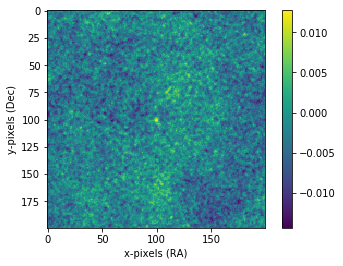

In [23]:
def show_fits(files):
    #show a fits file
    for file in files:
        hdulist = fits.open(file)
        data = hdulist[0].data

        # Plot the 2D array
        plt.imshow(data, cmap=plt.cm.viridis)
        plt.xlabel('x-pixels (RA)')
        plt.ylabel('y-pixels (Dec)')
        plt.colorbar()
        plt.show()

#show a fit file and plot the brightest point
def load_fits(filename):
    #loads the file
    hdulist = fits.open(filename)
    data = hdulist[0].data
    #finds the brightest point
    arg_max = np.argmax(data)
    max_pos = np.unravel_index(arg_max,data.shape)
    return max_pos

#mean of a set of fits files
def mean_fits(files):
    n = len(files)
    
    hdulist = fits.open(files[0])
    data = hdulist[0].data
    hdulist.close()
    
    for i in range(1, n):
        hdulist = fits.open(files[i])
        data = data + hdulist[0].data
        hdulist.close()

    mean = data / n
    return mean


mean = mean_fits(['image0.fits','image1.fits'])
plt.imshow(mean, cmap=plt.cm.viridis)
plt.xlabel('x-pixels (RA)')
plt.ylabel('y-pixels (Dec)')
plt.colorbar()
plt.show()

In [ ]:
#write a function that returns the mean and median
def list_stats(list):
    n = len(list)
    a = n % 2
    if a > 0:
        list.sort()
        mid = n//2
        median = list[mid]
    else:
        list.sort()
        mid = n//2
        median = (list[mid - 1] + list[mid])/2
    c = 0
    for numbers in list:
        c = c + numbers
    mean = c / n
    return median,mean

In [24]:
#write a funtion that returns the median of a fits image
import time, numpy as np
from astropy.io import fits

def median_fits(filenames):

    start = time.time()
    FITS_list = []
    for filename in filenames: 
        hdulist = fits.open(filename)
        FITS_list.append(hdulist[0].data)
        hdulist.close()
    FITS_stack = np.dstack(FITS_list)
    median = np.median(FITS_stack, axis=2)

    memory = FITS_stack.nbytes

    memory /= 1024
  
    stop = time.time() - start   # stop timer
    return median, stop, memory

median_fits(['image0.fits','image1.fits'])

(array([[-1.23070559e-03, -4.58900802e-04,  3.10387416e-03, ...,
         -5.38753299e-03,  6.89948356e-05,  4.95989923e-04],
        [ 7.33028952e-04, -3.99116034e-04, -1.43243704e-03, ...,
         -3.08441650e-03, -2.93457438e-03,  1.49579206e-03],
        [-3.80291452e-03, -1.35699217e-03,  7.37010268e-05, ...,
         -1.42783194e-03, -3.54813517e-03, -6.01352949e-04],
        ...,
        [-4.16759355e-03, -5.15464949e-03, -5.37102716e-03, ...,
         -3.47000652e-03, -3.36867012e-03,  1.46178508e-03],
        [-5.57127967e-03, -2.86332774e-03, -2.08433348e-03, ...,
         -5.41632483e-03, -3.81230842e-03, -2.19331519e-03],
        [-4.41562966e-03, -5.15643158e-03, -1.05315816e-03, ...,
         -7.04425969e-03, -6.75344700e-03, -2.41667614e-03]]),
 0.07254576683044434,
 625.0)

In [4]:
#write two functions that use binapprox on lists of numbers and returns an approximate median
def median_bins(values, B):
    mean = np.mean(values)
    std = np.std(values)
    left_bin = 0
    bins = np.zeros(B)
    bin_width = 2*std/B
    for value in values:
        if value < mean - std:
            left_bin = left_bin + 1
        elif value < mean + std:
            bin = int((value - (mean - std))/bin_width)
            bins[bin] = bins[bin] + 1
        
    return mean, std, left_bin, bins
  
def median_approx(values, B):
    mean, std, left_bin, bins = median_bins(values, B)
    count = left_bin
    
    mid = (len(values)+1)/2
    for b, bincount in enumerate(bins):
        count = count + bincount
        if count >= mid:
            break
            
    width = 2*std/B
    median = mean - std + width*(b+0.5)
    return median

median_approx([1,2,3,4],50)

3.0142956348249514

In [ ]:
#do the above with fits files
import time, numpy as np
from astropy.io import fits
from helper import running_stats


def median_bins_fits(filenames, B):
  # Calculate the mean and standard dev
  mean, std = running_stats(filenames)
    
  dim = mean.shape # Dimension of the FITS file arrays
    
  # Initialise bins
  left_bin = np.zeros(dim)
  bins = np.zeros((dim[0], dim[1], B))
  bin_width = 2 * std / B 

  # Loop over all FITS files
  for filename in filenames:
      hdulist = fits.open(filename)
      data = hdulist[0].data

      # Loop over every point in the 2D array
      for i in range(dim[0]):
        for j in range(dim[1]):
          value = data[i, j]
          mean_ = mean[i, j]
          std_ = std[i, j]

          if value < mean_ - std_:
            left_bin[i, j] += 1
                
          elif value >= mean_ - std_ and value < mean_ + std_:
            bin = int((value - (mean_ - std_))/bin_width[i, j])
            bins[i, j, bin] += 1

  return mean, std, left_bin, bins


def median_approx_fits(filenames, B):
  mean, std, left_bin, bins = median_bins_fits(filenames, B)
    
  dim = mean.shape # Dimension of the FITS file arrays
    
  # Position of the middle element over all files
  N = len(filenames)
  mid = (N + 1)/2
	
  bin_width = 2*std / B
  # Calculate the approximated median for each array element
  median = np.zeros(dim)   
  for i in range(dim[0]):
    for j in range(dim[1]):    
      count = left_bin[i, j]
      for b, bincount in enumerate(bins[i, j]):
        count += bincount
        if count >= mid:
          # Stop when the cumulative count exceeds the midpoint
          break
      median[i, j] = mean[i, j] - std[i, j] + bin_width[i, j]*(b + 0.5)
      
  return median